In [2]:
import glob
import numpy as np
import pandas as pd
import scipy.stats as st
from scipy.io import loadmat
from pingouin import rm_anova
import matplotlib.pyplot as plt

In C:\Users\Hong\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Hong\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Hong\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\Hong\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Hong\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle

# Model Assignment

In [150]:
files = glob.glob('raw/8/*.mat')

categorizations = {'00': [], '01': [], '10': [], '11': []}

df = 10
n = 18
for f in files:
    subject = f[6:f.find('.')]
    mat = loadmat(f)
    
    n2 = 72
    count_sig_aa = 0
    count_sig_ab = 0
    for i in range(1, 6):
        pAA_dat = mat[f'p_AA_{i}Diff'][0]
        pBB_dat = mat[f'p_BB_{i}Diff'][0]
        pAB_dat = mat[f'p_AB_{i}Diff'][0]
        pBA_dat = mat[f'p_BA_{i}Diff'][0]

        chi_squared = 0
        for pAA, pBB in zip(pAA_dat, pBB_dat):
            p_mean = (pAA+pBB)/2
            if p_mean == 0:
                p_mean += 1/2/n
            elif p_mean == 1:
                p_mean -= 1/2/n
            chi_squared += n*((pAA-p_mean)**2+(pBB-p_mean)**2)/p_mean/(1-p_mean)

        if 1-st.chi2.cdf(chi_squared, df) <= 0.05:
            count_sig_aa+=1

        chi_squared = 0
        for pAB, pBA in zip(pAB_dat, pBA_dat):
            p_mean = (pAB+pBA)/2
            if p_mean == 0:
                p_mean += 1/2/n2
            elif p_mean == 1:
                p_mean -= 1/2/n2
            chi_squared += n*((pAB-p_mean)**2+(pBA-p_mean)**2)/p_mean/(1-p_mean)

        if 1-st.chi2.cdf(chi_squared, df) <= 0.05:
            count_sig_ab+=1

    '''
    if count_sig_aa == 0:
        print('pAA==pBB')
    else:
        print('pAA!=pBB')
    if count_sig_ab == 0:
        print('pAA==pBA')
    else:
        print('pAB!=pBA')
    '''
        
    if count_sig_aa == 0 and count_sig_ab == 0:
        categorizations['11'].append(subject)
    elif count_sig_aa == 0 and count_sig_ab != 0:
        categorizations['10'].append(subject)
    elif count_sig_aa != 0 and count_sig_ab == 0:
        categorizations['01'].append(subject)
    elif count_sig_aa != 0 and count_sig_ab != 0:
        categorizations['00'].append(subject)
        
for category in categorizations.keys():
    print(category)
    print('========')
    print(categorizations[category])
    print()

00
['CP', 'HXT', 'LR', 'ZC', 'ZM', 'ZYC']

01
['HZL', 'LJJ']

10
['CW', 'CY', 'GJ', 'JYN', 'LXL', 'RSL', 'SJ', 'SJ2', 'SXQ', 'SYB', 'WJ', 'WY', 'YJX', 'ZQT', 'ZT']

11
['CSF', 'LT', 'ZBY']



# Plotting model vs. human in p-space

In [ ]:
types = ['AA', 'BB', 'AB', 'BA']
p_data = pd.read_csv('p_data.csv', index_col="Subject")

files = glob.glob('raw/8/*.mat')
ratings_threshold = 1.0

for f in files:
    dat = loadmat(f)
    subject = f[max(f.rfind('/'), f.rfind('\\'))+1:f.find('.')]

    num_ratings = 0
    for i in range(1, 6):
        if p_data.loc[subject][f'PF{i}'] <= ratings_threshold:
            num_ratings += 1
            
    points = []
    for t in types:
        points.append(np.concatenate([dat[f'p_{t}_{n+1}Diff'][0] for n in range(num_ratings)]))
    points = np.array(points).T

    model_pts = pd.read_csv(f'models/{subject}_points.csv', index_col=0)
    model_pts = [model_pts.iloc[p].tolist() for p in range(len(model_pts))]

    plt.clf()
    pF, pH = zip(*[((pAA+pBB)/2, (pAB+pBA)/2) for pAA, pBB, pAB, pBA in points])
    plt.scatter(pF, pH, marker='^', c='blue', label='Subject')
    pF, pH = zip(*[((pAA+pBB)/2, (pAB+pBA)/2) for pAA, pBB, pAB, pBA in model_pts])
    plt.scatter(pF, pH, marker='.', c='red', label='Model')
    plt.xlabel('p(F)')
    plt.ylabel('p(H)')
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.legend()
    plt.savefig(f'{subject}.png')

# Plotting pXY Comparisons

Text(0.06, 0.5, 'p_Model')

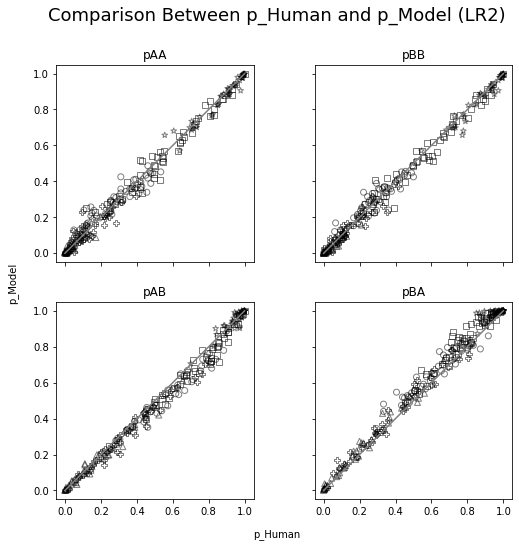

In [24]:
model_name = 'lr2'
ratings_threshold = 1.0

num_blocks = 10
types = ['AA', 'BB', 'AB', 'BA']
p_data = pd.read_csv('p_data.csv', index_col="Subject")
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(8.5, 8))

for t, ax in zip(types, axes.flat):

    files_human = []
    files_human.extend(glob.glob('raw/4/*.mat'))
    files_human.extend(glob.glob('raw/8/*.mat'))
    files_human.sort()

    files_model = []
    files_model.extend(glob.glob(f'models/{model_name}/4deg/*points.csv'))
    files_model.extend(glob.glob(f'models/{model_name}/8deg/*points.csv'))
    files_model.sort(key=lambda x: x.replace('_points', ''))

    types = ['AA', 'BB', 'AB', 'BA']
    markers = ['^', 'P', 'o', 's', '*']
    pXY_human = {i:[] for i in range(1, 6)}
    pXY_model = {i:[] for i in range(1, 6)}

    for f_human, f_model in zip(files_human, files_model):

        dat = loadmat(f_human)
        model_dat = pd.read_csv(f_model, index_col = 0)
        subject = f_human[max(f_human.rfind('/'), f_human.rfind('\\'))+1:f_human.find('.')]

        num_ratings = 0
        for i in range(1, 6):
            if p_data.loc[subject][f'PF{i}'] <= ratings_threshold:
                num_ratings += 1
        
        real_ratings = []
        for rating in range(num_ratings):
            tmp_check = np.concatenate([dat[f'p_{x}_{rating+1}Diff'][0] for x in types])
            if np.all(tmp_check == 0) or np.all(tmp_check == 1):
                continue
            if rating > 0 and rating < 5 and all([np.all(dat[f'p_{t}_{rating+1}Diff'][0] == dat[f'p_{t}_{rating}Diff'][0]) for t in types]):
                continue

            pXY_human[rating+1].append(np.mean(dat[f'p_{t}_{rating+1}Diff'][0]))
            real_ratings.append(rating)

        for n, rating in enumerate(real_ratings):
            pXY_model[rating+1].append(np.mean(model_dat[f'p{t}'][num_blocks*n:num_blocks*(n+1)]))

    ax.plot([0, 1], [0, 1], linestyle='-', c='gray')
    for m, pH, pM in zip(markers, pXY_human.values(), pXY_model.values()):
        ax.set(adjustable='box', aspect='equal')
        ax.scatter(pH, pM, edgecolors='black', facecolors='none', marker=m, alpha=0.5)
        ax.set_title(f'p{t}')

fig.suptitle(f'Comparison Between p_Human and p_Model ({model_name.upper()})', fontsize=18)
fig.text(0.5, 0.06, 'p_Human', ha='center')
fig.text(0.06, 0.5, 'p_Model', va='center', rotation='vertical')
fig.savefig(f'results/{model_name[:2]}/{model_name.upper()}_comparison.svg')


# Residual Analysis

### Histogram Plot by Level

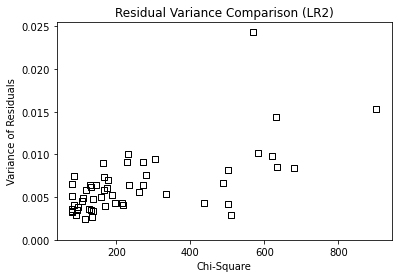

In [75]:
model_name = 'lr2'
num_blocks = 10
ratings_threshold = 1.0

files_human = []
files_human.extend(glob.glob('raw/4/*.mat'))
files_human.extend(glob.glob('raw/8/*.mat'))

files_model = []
files_model.extend(glob.glob(f'models/{model_name}/4deg/*points.csv'))
files_model.extend(glob.glob(f'models/{model_name}/8deg/*points.csv'))
files_model.sort(key=lambda x: x.replace('_points', ''))

fit_agg = pd.concat([pd.read_csv(f'results/{model_name[:2]}/{model_name}_4deg.csv', index_col='subject'), pd.read_csv(f'results/{model_name[:2]}/{model_name}_8deg.csv', index_col='subject')])

types = ['AA', 'BB', 'AB', 'BA']
p_data = pd.read_csv('p_data.csv', index_col="Subject")

x = []
y = []

for f_human, f_model in zip(files_human, files_model):
    
    dat = loadmat(f_human)
    model_dat = pd.read_csv(f_model, index_col=0)
    subject = f_human[max(f_human.rfind('/'), f_human.rfind('\\'))+1:f_human.find('.')]
    
    num_ratings = 0
    for i in range(1, 6):
        if p_data.loc[subject][f'PF{i}'] <= ratings_threshold:
            num_ratings += 1
    
    n = 0
    
    pXY_human = []
    pXY_model = []
    for rating in range(num_ratings):
        tmp_check = np.concatenate([dat[f'p_{t}_{rating+1}Diff'][0] for t in types])
        if np.all(tmp_check == 0) or np.all(tmp_check == 1):
            continue
        if rating > 0 and rating < 5 and all([np.all(dat[f'p_{t}_{rating+1}Diff'][0] == dat[f'p_{t}_{rating}Diff'][0]) for t in types]):
            continue

        pXY_human.extend(np.concatenate([dat[f'p_{t}_{rating+1}Diff'][0] for t in types]))
        pXY_model.extend(np.concatenate([model_dat[f'p{t}'][num_blocks*n:num_blocks*(n+1)] for t in types]))
        n += 1
        
    residuals = (np.array(pXY_human) - np.array(pXY_model))
    variance = np.var(residuals)
    y.append(variance)
    x.append(fit_agg.loc[subject]['chi-square'])

plt.scatter(x, y, edgecolors='black', facecolors='none', marker='s')
plt.xlabel('Chi-Square')
plt.ylabel('Variance of Residuals')
plt.ylim(0)
plt.title(f'Residual Variance Comparison ({model_name.upper()})')
plt.savefig(f'results/{model_name[:2]}/{model_name.upper()}_residvar.svg')

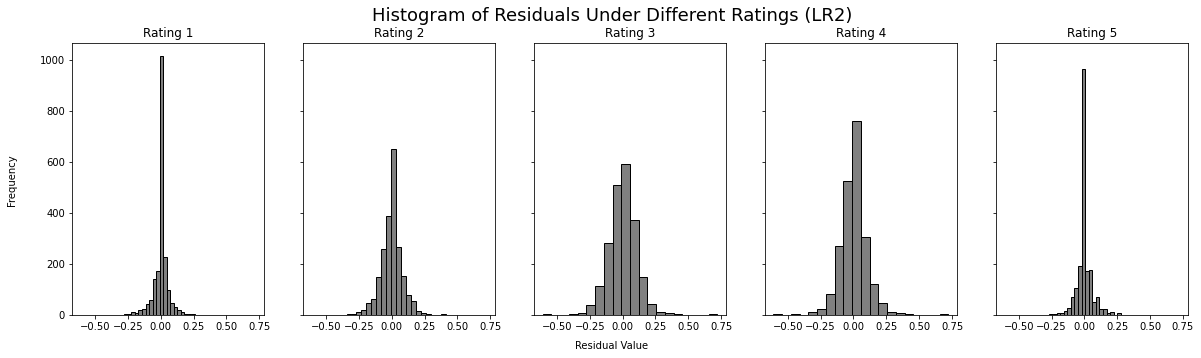

In [74]:
model_name = 'lr2'
ratings_threshold = 1.0
num_blocks = 10

files_human = []
files_human.extend(glob.glob('raw/4/*.mat'))
files_human.extend(glob.glob('raw/8/*.mat'))

files_model = []
files_model.extend(glob.glob(f'models/{model_name}/4deg/*points.csv'))
files_model.extend(glob.glob(f'models/{model_name}/8deg/*points.csv'))
files_model.sort(key=lambda x: x.replace('_points', ''))

p_data = pd.read_csv('p_data.csv', index_col="Subject")
types = ['AA', 'BB', 'AB', 'BA']
pXY_human = {i:[] for i in range(num_ratings)}
pXY_model = {i:[] for i in range(num_ratings)}

for f_human, f_model in zip(files_human, files_model):
    
    dat = loadmat(f_human)
    subject = f_human[max(f_human.rfind('/'), f_human.rfind('\\'))+1:f_human.find('.')]
    model_dat = pd.read_csv(f_model, index_col=0)

    num_ratings = 0
    for i in range(1, 6):
        if p_data.loc[subject][f'PF{i}'] <= ratings_threshold:
            num_ratings += 1
    
    n = 0
    for rating in range(num_ratings):
        tmp_check = np.concatenate([dat[f'p_{t}_{rating+1}Diff'][0] for t in types])
        if np.all(tmp_check == 0) or np.all(tmp_check == 1):
            continue
        if rating > 0 and rating < 5 and all([np.all(dat[f'p_{t}_{rating+1}Diff'][0] == dat[f'p_{t}_{rating}Diff'][0]) for t in types]):
            continue

        pXY_human[rating].extend(np.concatenate([dat[f'p_{t}_{rating+1}Diff'][0] for t in types]))
        pXY_model[rating].extend(np.concatenate([model_dat[f'p{t}'][num_blocks*n:num_blocks*(n+1)] for t in types]))
        n += 1

pXY_residuals = {key:np.array(pM) - np.array(pH) for key, (pH, pM) in enumerate(zip(pXY_human.values(), pXY_model.values()))}
#zXY_residuals = {key:np.array(st.norm.ppf(pM)) - np.array(st.norm.ppf(pH)) for key, (pH, pM) in enumerate(zip(pXY_human.values(), pXY_model.values()))}
'''
fvalue, pvalue = st.f_oneway(*[pXY_residuals[i] for i in d])

print(f'p-value is {round(pvalue, 4)}.')
if pvalue < 0.05:
    print('Null hypothesis rejected. Significant difference between group means.')
else:
    print('Unable to reject null hypothesis.')
'''

n_ratings = len(pXY_residuals.keys())
fig, axes = plt.subplots(1, n_ratings, sharex=True, sharey=True, figsize=(n_ratings*4, 5))
for i, (vals, ax) in enumerate(zip(pXY_residuals.values(), axes.flat)):
    vals = [v for v in vals if abs(v) != np.inf]
    ax.hist(vals, bins=20, color='gray', ec='black')
    ax.set_title(f'Rating {i+1}')
#axes[-1, -1].text(0.5, 0.5, f'ANOVA p-value: {round(pvalue, 4)}', horizontalalignment='center', verticalalignment='center', transform=axes[-1, -1].transAxes, fontsize=18)

fig.suptitle(f'Histogram of Residuals Under Different Ratings ({model_name.upper()})', fontsize=18)

fig.text(0.5, 0.03, 'Residual Value', ha='center')
fig.text(.08, 0.5, 'Frequency', va='center', rotation='vertical')
fig.savefig(f'results/{model_name[:2]}/{model_name.upper()}_presiduals.svg')

### RM ANOVA Across Level and pXY

In [200]:
model_name = 'cc2a'

if 'cc' in model_name or 'rc' in model_name:
    ratings_threshold = 0.5
else:
    ratings_threshold = 1.0

num_blocks = 10

files_human = []
files_human.extend(glob.glob('raw/4/*.mat'))
files_human.extend(glob.glob('raw/8/*.mat'))

files_model = []
files_model.extend(glob.glob(f'models/{model_name}/4deg/*points.csv'))
files_model.extend(glob.glob(f'models/{model_name}/8deg/*points.csv'))
files_model.sort(key=lambda x: x.replace('_points', ''))

types = ['AA', 'BB', 'AB', 'BA']
p_data = pd.read_csv('p_data.csv', index_col="Subject")

df = pd.DataFrame(columns=['Subject', 'pXY', 'Level', 'Residual'])

for f_human, f_model in zip(files_human, files_model):
    
    dat = loadmat(f_human)
    subject = f_human[max(f_human.rfind('/'), f_human.rfind('\\'))+1:f_human.find('.')]
    model_dat = pd.read_csv(f_model, index_col=0)
    
    if p_data.loc[subject]['Accuracy'] <= 0.52:
        continue
    
    num_ratings = 0
    for i in range(1, 6):
        if p_data.loc[subject][f'PF{i}'] <= ratings_threshold:
            num_ratings += 1
    
    n = 0
    for rating in range(num_ratings):
        tmp_check = np.concatenate([dat[f'p_{t}_{rating+1}Diff'][0] for t in types])
        if np.all(tmp_check == 0) or np.all(tmp_check == 1):
            continue
        if rating > 0 and rating < 5 and all([np.all(dat[f'p_{t}_{rating+1}Diff'][0] == dat[f'p_{t}_{rating}Diff'][0]) for t in types]):
            continue

        for t in types:
            mean = np.mean(np.array(model_dat[f'p{t}'][num_blocks*n:num_blocks*(n+1)]) - np.array(dat[f'p_{t}_{rating+1}Diff'][0]))
            df.loc[len(df)] = [subject, f'p{t}', rating+1, mean]
        n += 1

res = rm_anova(data=df, dv='Residual', within=['pXY', 'Level'], subject='Subject')
res = res.rename(columns={'ddof1': 'df_num', 'ddof2': 'df_denom'})
print('4x5 on pXY and Level:')
print(res.iloc[:, :-3])
print()

res = rm_anova(data=df, dv='Residual', within=['pXY'], subject='Subject')
res = res.rename(columns={'ddof1': 'df_num', 'ddof2': 'df_denom'})
print('4x1 on pXY:')
print(res)
print()

df_extlevel = df[(df['Level'] == min(df['Level'])) | (df['Level'] == min(df['Level'])+1)]
res = rm_anova(data=df_extlevel, dv='Residual', within=['pXY', 'Level'], subject='Subject')
res = res.rename(columns={'ddof1': 'df_num', 'ddof2': 'df_denom'})
print('4x2 on pXY and extreme Level:')
print(res.iloc[:, :-3])
print()

4x5 on pXY and Level:
        Source        SS  df_num  df_denom        MS            F  \
0          pXY  0.541029       3       129  0.180343    12.830504   
1        Level  2.034066       3       129  0.678022 -5216.550854   
2  pXY * Level  0.402675       9       387  0.044742    88.676482   

          p-unc  
0  2.170949e-07  
1  1.000000e+00  
2  2.039140e-88  

4x1 on pXY:
  Source  df_num  df_denom          F         p-unc       np2       eps
0    pXY       3       129  11.605867  8.750841e-07  0.212539  0.406243

4x2 on pXY and extreme Level:
        Source        SS  df_num  df_denom        MS          F     p-unc
0          pXY  0.196119       3       129  0.065373  10.636026  0.000003
1        Level  0.000140       1        43  0.000140   2.018985  0.162555
2  pXY * Level  0.017822       3       129  0.005941   5.666125  0.001119



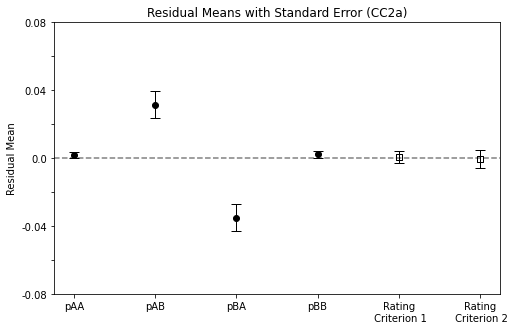

In [201]:
df_to_use = df if ratings_threshold == 1.0 else df_extlevel

plt.figure(figsize=(12 if ratings_threshold == 1.0 else 8, 5))
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)

x = list(df_to_use.groupby(by='pXY')['Residual'].mean().index)
y = list(df_to_use.groupby(by='pXY')['Residual'].mean())
yerr = list(df_to_use.groupby(by='pXY')['Residual'].sem())

plt.scatter(x, y, c='black')
plt.errorbar(x, y, yerr=yerr, fmt='none', elinewidth=1, ecolor='black', capsize=5)

x = [f'Rating\n Criterion {level}' for level in df_to_use.groupby(by='Level')['Residual'].mean().index]
y = df_to_use.groupby(by='Level')['Residual'].mean()
yerr = list(df_to_use.groupby(by='Level')['Residual'].sem())

plt.scatter(x, y, marker='s', edgecolors='black', facecolors='none')
plt.errorbar(x, y, yerr=yerr, fmt='none', elinewidth=1, ecolor='black', capsize=5)

xmin, xmax, ymin, ymax = plt.axis()
plt.ylim(bottom=-0.08, top=0.08)

mn_upper = model_name.upper()
if model_name == 'cc2a':
    mn_upper = 'CC2a'

ticks = [round(t, 2) for t in np.arange(-0.08, 0.1, step=0.02)]
labels = ['' if i%2 == 1 else n for i, n in enumerate(ticks)]
plt.yticks(ticks, labels)

plt.title(f'Residual Means with Standard Error ({mn_upper})')
plt.ylabel('Residual Mean')

plt.savefig(f'{model_name}_eb.png')

### RM ANOVA Across Level and pXY w/ Filtered Subjects

In [3]:
model_name = 'df2'
ratings_threshold = 1.0
num_blocks = 10

files_human = []
files_human.extend(glob.glob('raw/4/*.mat'))
files_human.extend(glob.glob('raw/8/*.mat'))

files_model = []
files_model.extend(glob.glob(f'models/{model_name}/4deg/*points.csv'))
files_model.extend(glob.glob(f'models/{model_name}/8deg/*points.csv'))
files_model.sort(key=lambda x: x.replace('_points', ''))

types = ['AA', 'BB', 'AB', 'BA']
p_data = pd.read_csv('p_data.csv', index_col="Subject")

df = pd.DataFrame(columns=['Subject', 'pXY', 'Level', 'Residual'])
fit_agg = pd.concat([pd.read_csv(f'results/{model_name[:2]}/{model_name}_8deg.csv', index_col='subject'), 
                     pd.read_csv(f'results/{model_name[:2]}/{model_name}_4deg.csv', index_col='subject')])

for f_human, f_model in zip(files_human, files_model):
    
    dat = loadmat(f_human)
    subject = f_human[max(f_human.rfind('/'), f_human.rfind('\\'))+1:f_human.find('.')]
    model_dat = pd.read_csv(f_model, index_col=0)
    
    if fit_agg.loc[subject]['explainable']:
        num_ratings = 0
        for i in range(1, 6):
            if p_data.loc[subject][f'PF{i}'] <= ratings_threshold:
                num_ratings += 1

        n = 0
        for rating in range(num_ratings):
            tmp_check = np.concatenate([dat[f'p_{t}_{rating+1}Diff'][0] for t in types])
            if np.all(tmp_check == 0) or np.all(tmp_check == 1):
                continue
            if rating > 0 and rating < 5 and all([np.all(dat[f'p_{t}_{rating+1}Diff'][0] == dat[f'p_{t}_{rating}Diff'][0]) for t in types]):
                continue

            for t in types:
                mean = np.mean(np.array(model_dat[f'p{t}'][num_blocks*n:num_blocks*(n+1)]) - np.array(dat[f'p_{t}_{rating+1}Diff'][0]))
                df.loc[len(df)] = [subject, f'p{t}', rating+1, mean]
            n += 1

res = rm_anova(data=df, dv='Residual', within=['pXY'], subject='Subject')
res = res.rename(columns={'ddof1': 'df_num', 'ddof2': 'df_denom'})
print(res)

C:\Users\Hong\Anaconda3\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.7, the latest is 0.3.8.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


  Source  df_num  df_denom         F     p-unc       np2       eps
0    pXY       3        75  2.647036  0.055097  0.095744  0.659768


In [12]:
model_name = 'df2'
num_ratings = 5
num_blocks = 10

files_human = []
files_human.extend(glob.glob('raw/4/*.mat'))
files_human.extend(glob.glob('raw/8/*.mat'))

files_model = []
files_model.extend(glob.glob(f'models/{model_name}/4deg/*points.csv'))
files_model.extend(glob.glob(f'models/{model_name}/8deg/*points.csv'))
files_model.sort(key=lambda x: x.replace('_points', ''))

types = ['AA', 'BB', 'AB', 'BA']

df = pd.DataFrame(columns=['Subject', 'pXY', 'Level', 'Residual'])
fit_agg = pd.concat([pd.read_csv(f'results/{model_name[:2]}/{model_name}_8deg.csv', index_col='subject'), 
                     pd.read_csv(f'results/{model_name[:2]}/{model_name}_4deg.csv', index_col='subject')])

for f_human, f_model in zip(files_human, files_model):
    
    dat = loadmat(f_human)
    subject = f_human[max(f_human.rfind('/'), f_human.rfind('\\'))+1:f_human.find('.')]
    model_dat = pd.read_csv(f_model, index_col=0)
    
    if not fit_agg.loc[subject]['rejected']:
        n = 0
        for rating in range(num_ratings):
            tmp_check = np.concatenate([dat[f'p_{t}_{rating+1}Diff'][0] for t in types])
            if np.all(tmp_check == 0) or np.all(tmp_check == 1):
                continue
            if rating > 0 and rating < 5 and all([np.all(dat[f'p_{t}_{rating+1}Diff'][0] == dat[f'p_{t}_{rating}Diff'][0]) for t in types]):
                continue

            for t in types:
                a = np.array(st.norm.ppf(model_dat[f'p{t}'][num_blocks*n:num_blocks*(n+1)]))
                b = np.array(st.norm.ppf(dat[f'p_{t}_{rating+1}Diff'][0]))
                c = np.array([x for x, y in zip(a, b) if abs(x) != np.inf and abs(y) != np.inf])
                d = np.array([y for x, y in zip(a, b) if abs(x) != np.inf and abs(y) != np.inf])

                if len(c) != 0:
                    mean = np.mean(c - d)
                    df.loc[len(df)] = [subject, f'p{t}', rating+1, mean]

                #mean = np.mean(np.array(model_dat[f'p{t}'][num_blocks*n:num_blocks*(n+1)]) - np.array(dat[f'p_{t}_{rating+1}Diff'][0]))
                #df.loc[len(df)] = [subject, f'p{t}', rating+1, mean]

            n += 1

res = rm_anova(data=df, dv='Residual', within=['Level', 'pXY'], subject='Subject')
res = res.rename(columns={'ddof1': 'df_num', 'ddof2': 'df_denom'})
print(res)

        Source        SS  df_num  df_denom        MS          F         p-unc  \
0        Level  3.545142       4        88  0.886286  10.827581  3.489567e-07   
1          pXY  0.299547       3        66  0.099849   1.849785  1.467375e-01   
2  Level * pXY  1.850806      12       264  0.154234  -9.236356  1.000000e+00   

   p-GG-corr       np2       eps  
0   0.000074  0.329832  0.557078  
1   0.156108  0.077560  0.859069  
2   1.000000 -0.723646  0.236769  


C:\Users\Hong\Anaconda3\lib\site-packages\pingouin\distribution.py:460: UserWarning: Epsilon values might be innaccurate in two-way repeated measures design where each  factor has more than 2 levels. Please  double-check your results.
  warnings.warn("Epsilon values might be innaccurate in "
